In [1]:
#install.packages('doParallel')
#install.packages('LiblineaR')
#install.packages('gbm')
#install.packages('e1071')
#install.packages('kernlab')
#install.packages('MLmetrics')
#install.packages('xgboost')

In [2]:
rm(list=ls())
########## Aux functions 
createPartition <- function(data_, p=0.7){
t <- unique(data_$device)
n <- length(t)
n.p <- round(n*p, 0)
t.sample <- sample(t, n.p)
train.index <- which( data_$device %in% t.sample)
return(train.index)
}
require(doParallel) #ugly parallel in R but useful  
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
data.raw <- read.csv(file='device_failure.csv') # few records kernels function works fine 
sum(is.na(data.raw)) # not nulls thank you :D
sapply(data.raw, class)
require(lubridate) # easy handle datetimes
require(dplyr) # like SQL in R, and also load pipe operator 
require(ggplot2) # easy, fast  adn nice plots 
data.raw %>% arrange(device, date) %>% mutate(date = ymd(date) ) -> data.raw
names(data.raw)
data.raw %>% group_by(device) %>% arrange(device, date) %>%
  mutate( l.attribute1 = lag(attribute1), 
          l.attribute2 = lag(attribute2), 
          l.attribute3 = lag(attribute3), 
          l.attribute4 = lag(attribute4), 
          l.attribute5 = lag(attribute5), 
          l.attribute6 = lag(attribute6), 
          l.attribute7 = lag(attribute7), 
          l.attribute8 = lag(attribute8), 
          l.attribute9 = lag(attribute9)) -> data.raw 
sum(data.raw$failure)
data.raw <- na.omit(data.raw)
# only each device has 0 or 1 failure, and if has a failure it's the last row
n.fails.index <- which(data.raw$failure==1) #only 106 failures 
nn.fails <- data.raw[ rep(n.fails.index, each=9) + -4:4, ]

[1] 0

date     device    failure attribute1 attribute2 attribute3 attribute4 
  "factor"   "factor"  "integer"  "integer"  "integer"  "integer"  "integer" 
attribute5 attribute6 attribute7 attribute8 attribute9 
 "integer"  "integer"  "integer"  "integer"  "integer"

Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2


[1] "date"       "device"     "failure"    "attribute1" "attribute2"
 [6] "attribute3" "attribute4" "attribute5" "attribute6" "attribute7"
[11] "attribute8" "attribute9"

[1] 106

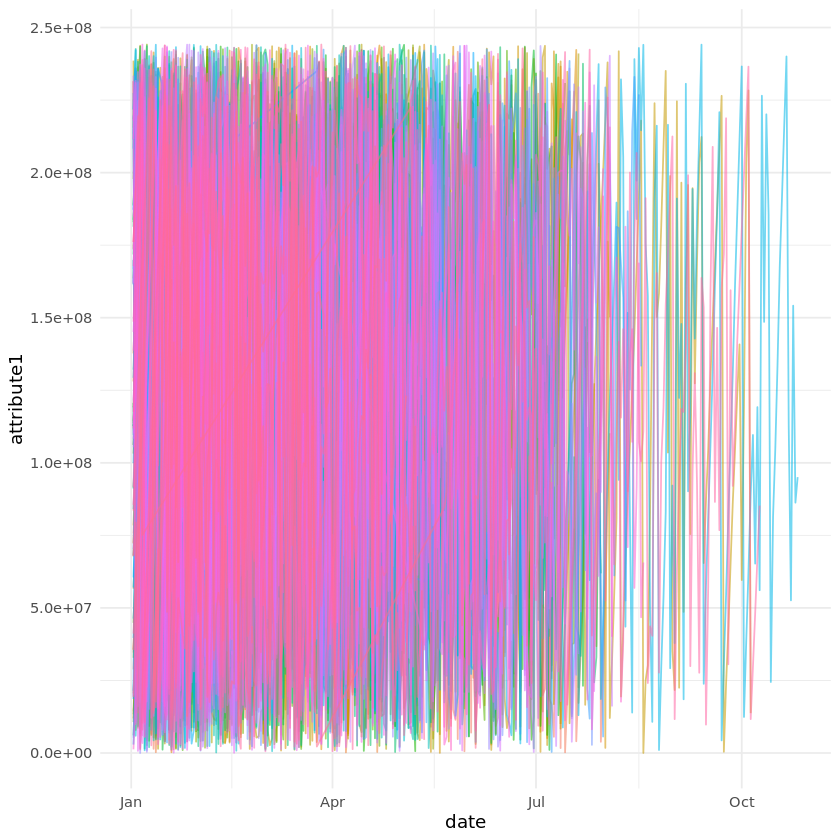

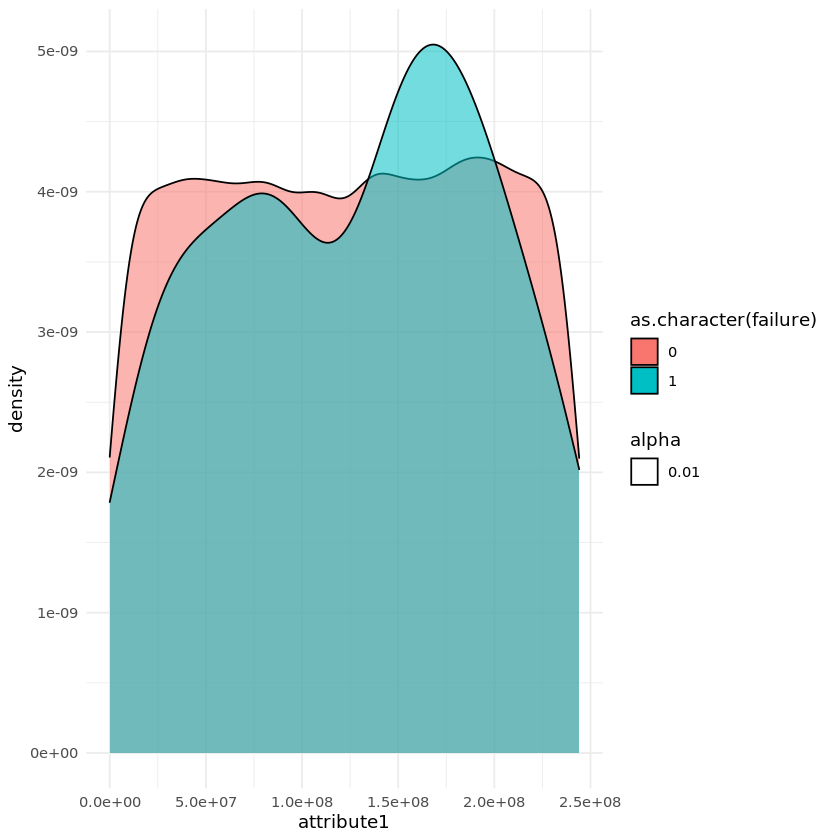

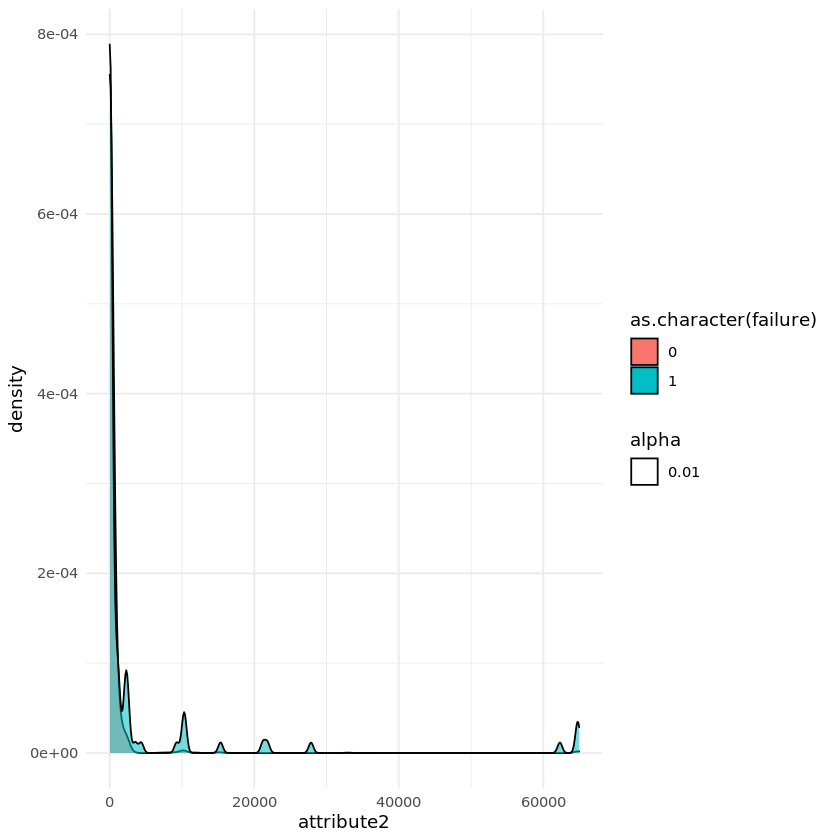

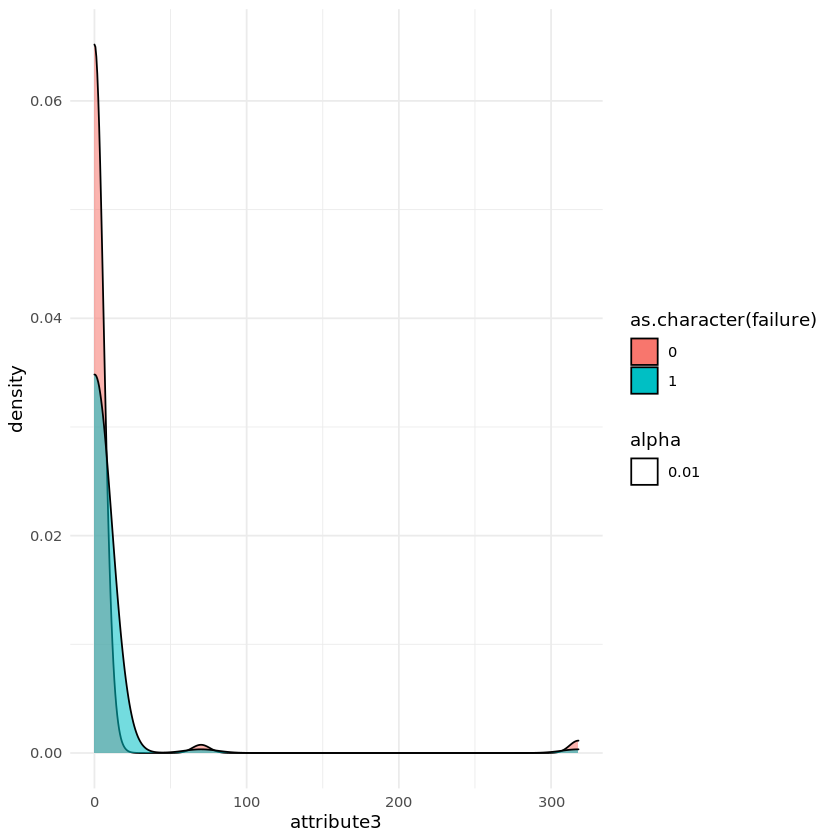

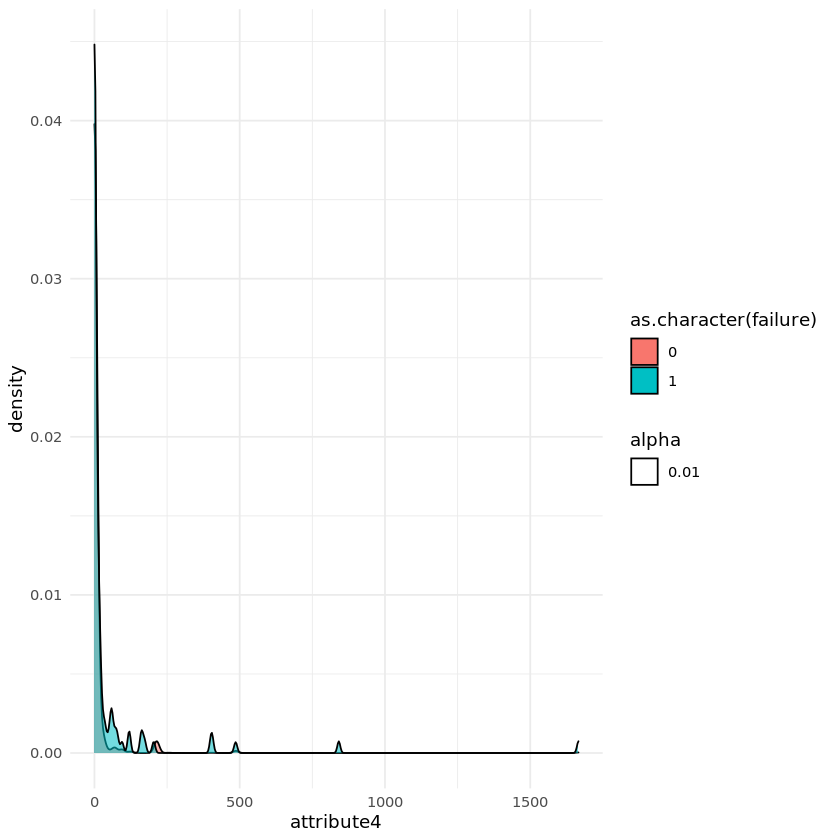

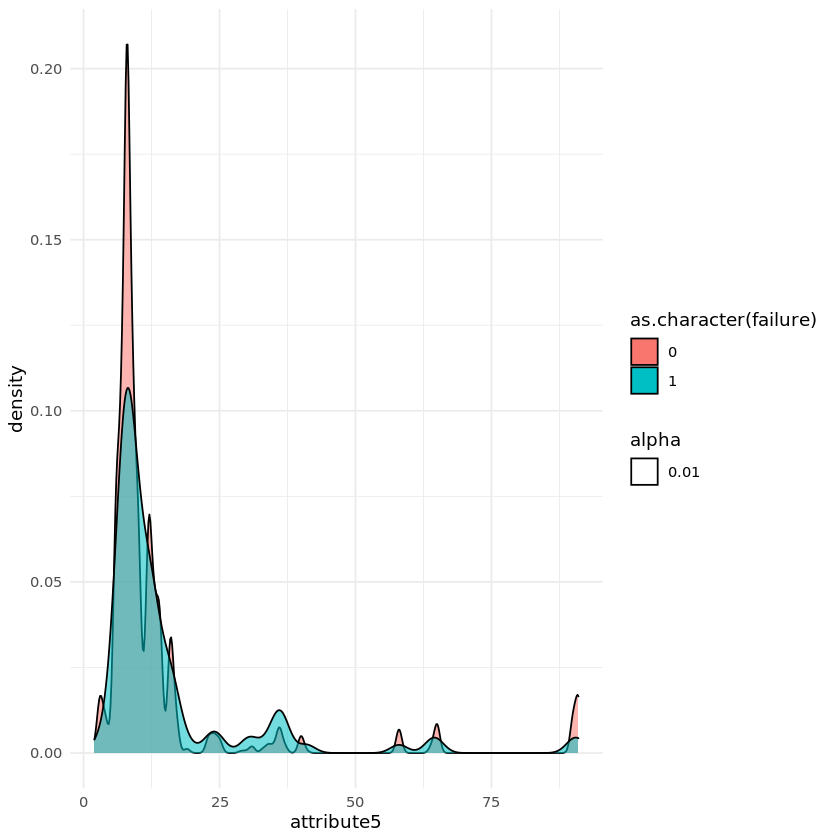

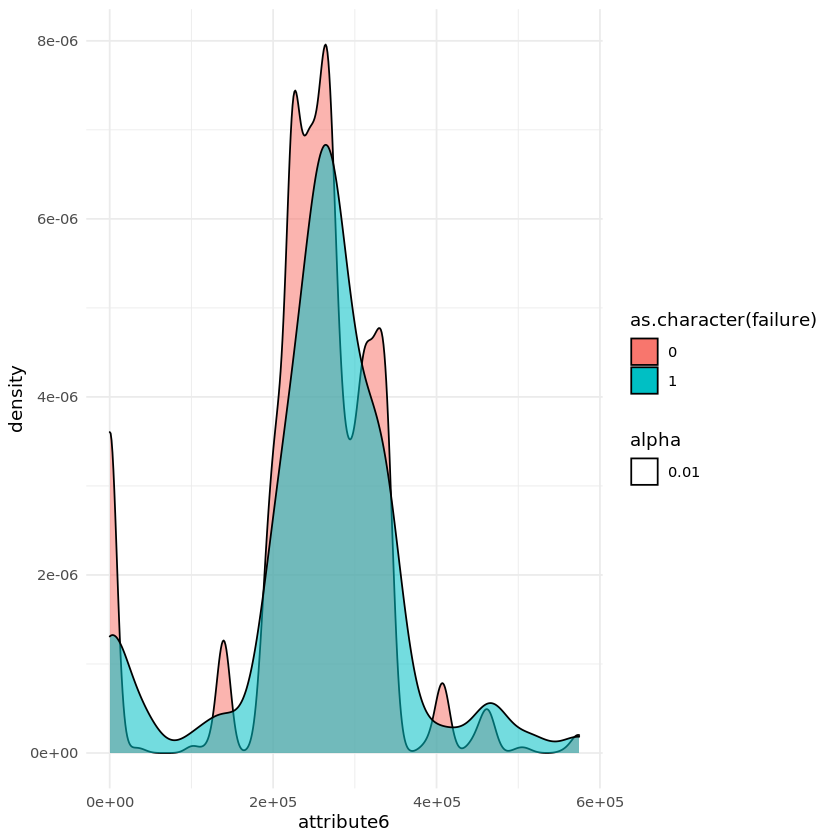

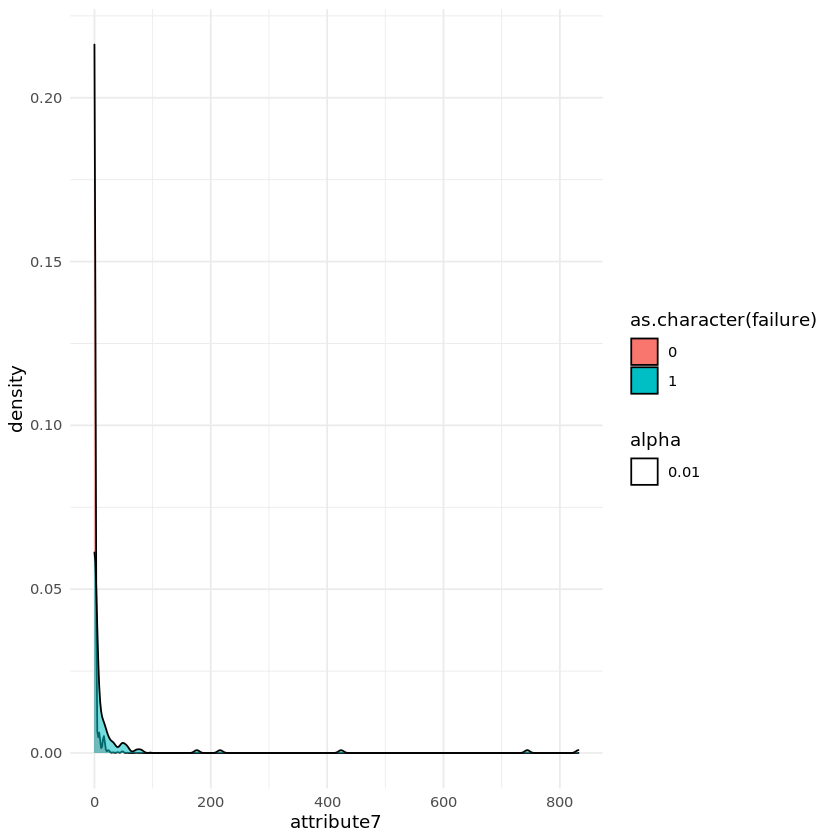

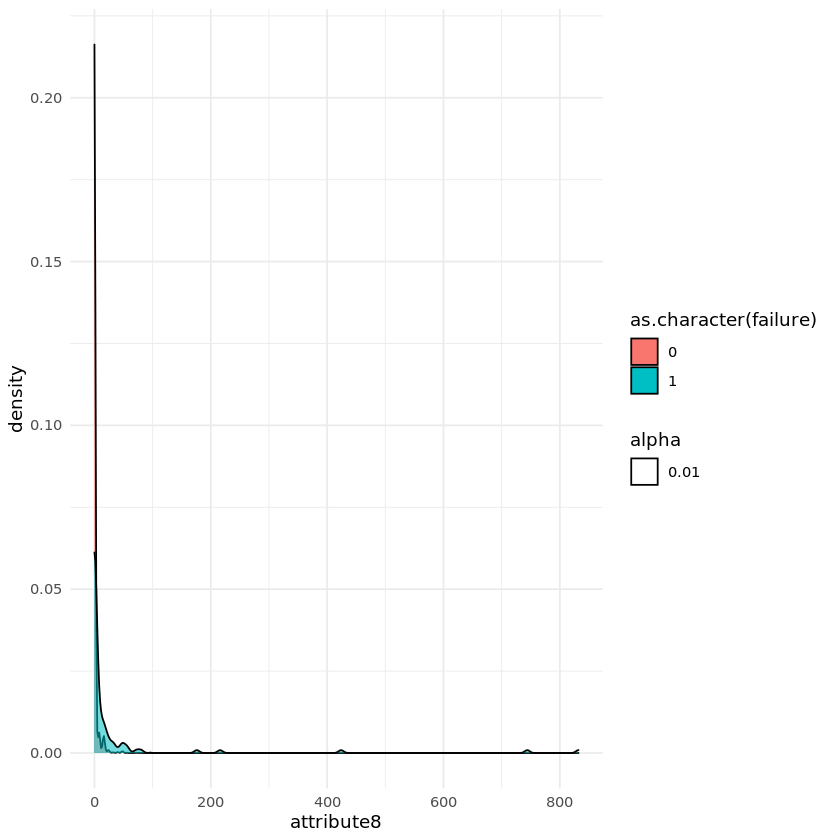

      date                 device        failure           attribute1       
 Min.   :2015-01-02   W1F0T0B1: 298   Min.   :0.000000   Min.   :     4224  
 1st Qu.:2015-01-31   Z1F14BGY: 281   1st Qu.:0.000000   1st Qu.: 61045068  
 Median :2015-03-12   S1F0JGJV: 277   Median :0.000000   Median :123450384  
 Mean   :2015-03-22   Z1F0MRPJ: 229   Mean   :0.009993   Mean   :122672510  
 3rd Qu.:2015-05-02   W1F11ZG9: 228   3rd Qu.:0.000000   3rd Qu.:184160428  
 Max.   :2015-10-26   W1F1CB5E: 215   Max.   :1.000000   Max.   :244135688  
                      (Other) :9079                                         
   attribute2       attribute3       attribute4       attribute5  
 Min.   : 0.000   Min.   :0.0000   Min.   :0.0000   Min.   : 2.0  
 1st Qu.: 0.000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 8.0  
 Median : 0.000   Median :0.0000   Median :0.0000   Median : 9.0  
 Mean   : 1.373   Mean   :0.2365   Mean   :0.5074   Mean   :14.2  
 3rd Qu.: 0.000   3rd Qu.:0.0000   3rd Qu.:0.0000

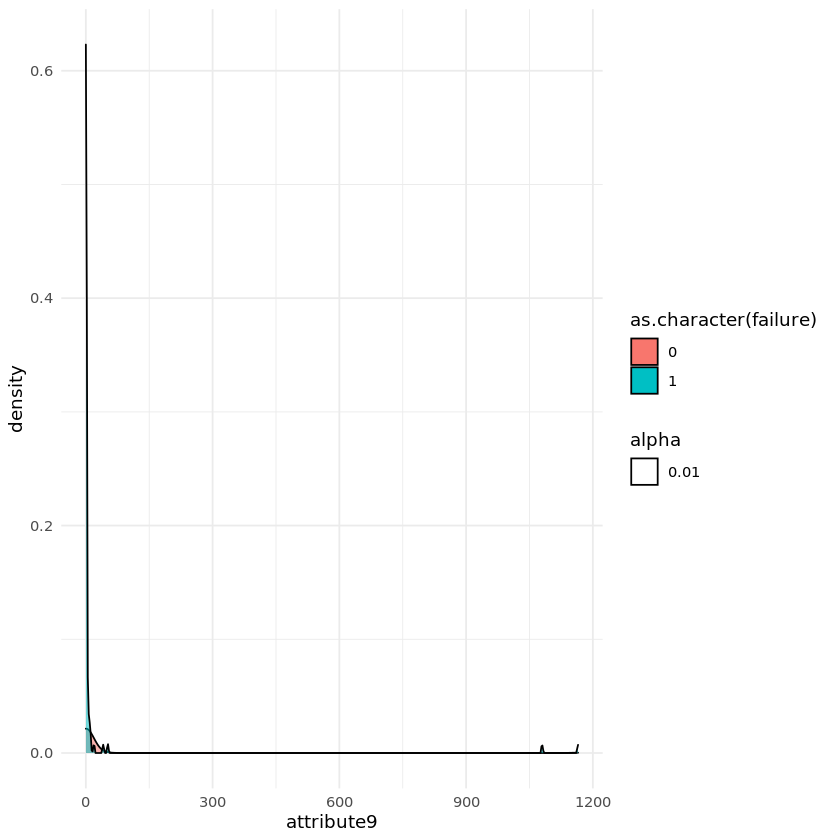

In [4]:
## Focus on success stories
#########################
device.with.failures <- unique(data.raw$device[n.fails.index] )
data.sample <- data.raw[ data.raw$device %in% device.with.failures, ]

write.csv(data.sample, row.names = FALSE, file='failures_SUPER.csv')
ggplot(data.sample, aes(date, attribute1, color= device, alpha=.03 )) + 
  geom_line() +   theme_minimal() + 
  theme(legend.position="none") 
ggplot(data.sample, aes(attribute1, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute2, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute3, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute4, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute5, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute6, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute7, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute8, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute9, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
index.columns <- c(2, 3, 4, 7, 8, 9:18) + 3 
# log features selected 
data.sample[, names(data.sample)[index.columns]] <-  
  log(data.sample[, names(data.sample)[index.columns]] + 1 )
# standar features 
index.columns <- grep('attr', names(data.sample))
summary(data.sample)
index.columns <- grep('attr', names(data.sample))

for ( i in index.columns ){
  temp <- data.sample[, names(data.sample)[i]]
  data.sample[, names(data.sample)[i]] <- scale(temp)
}

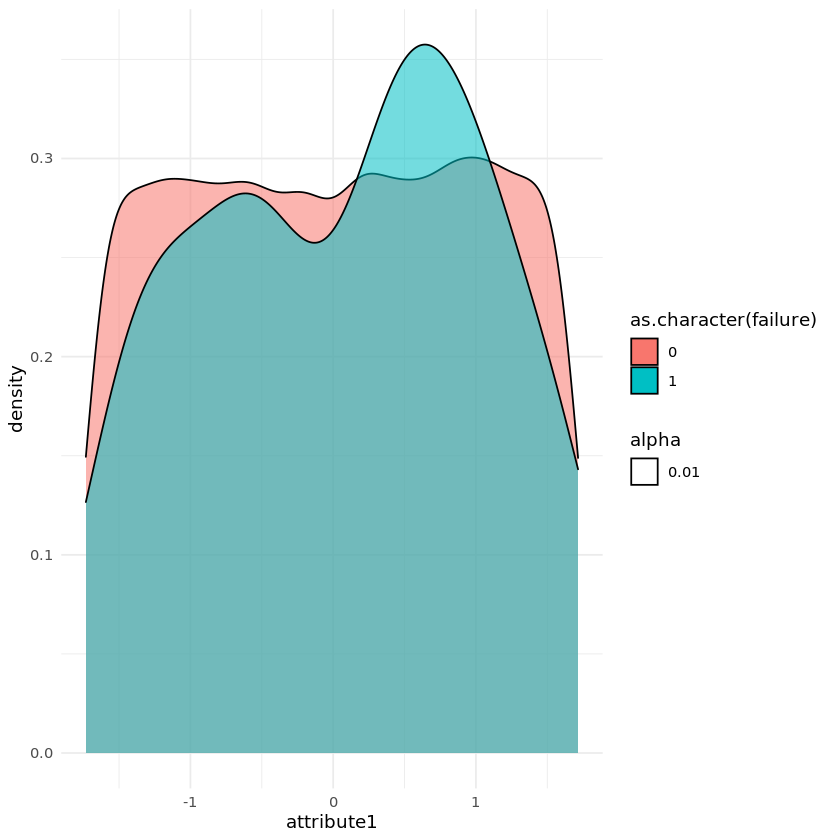

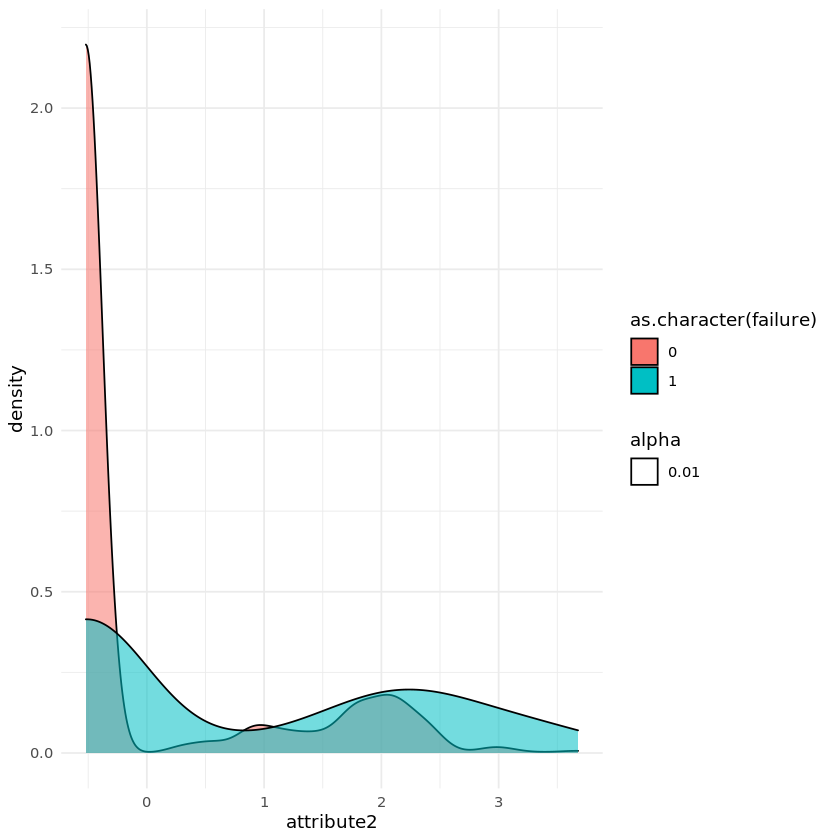

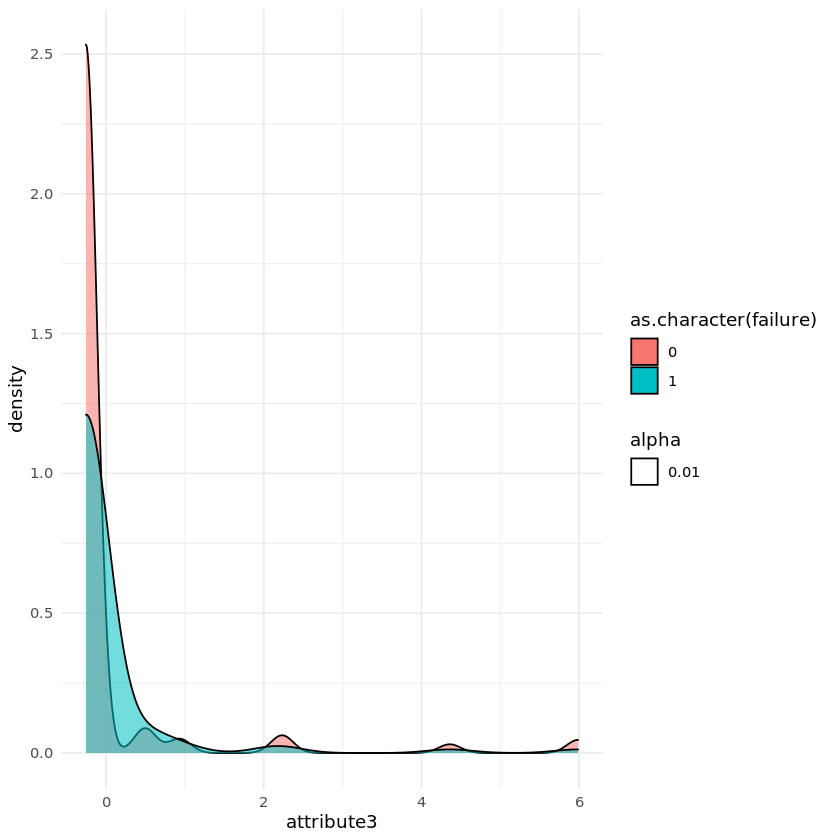

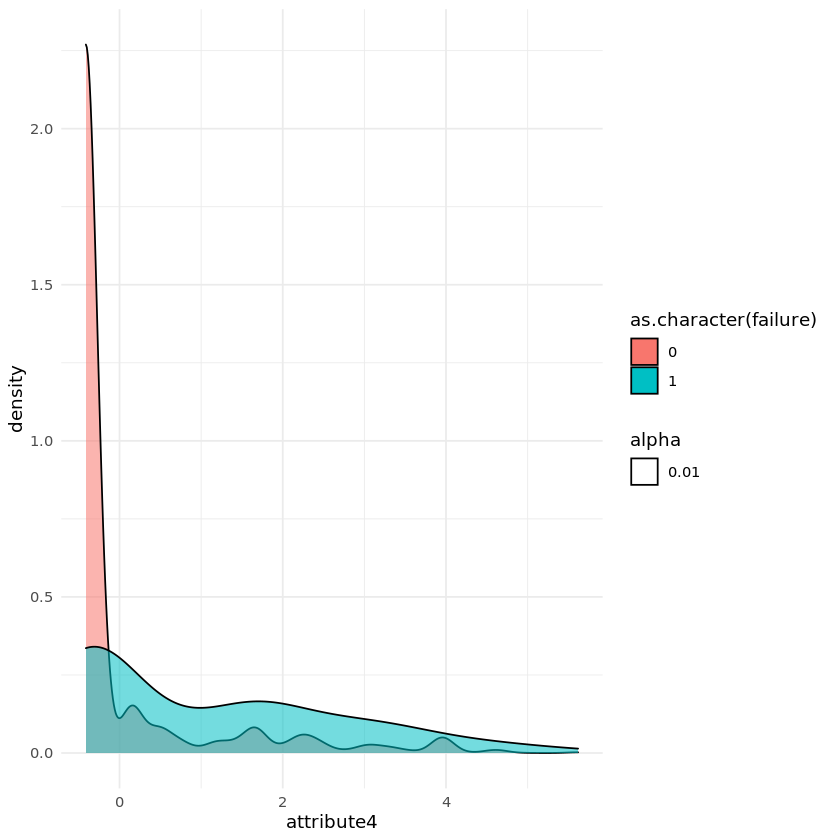

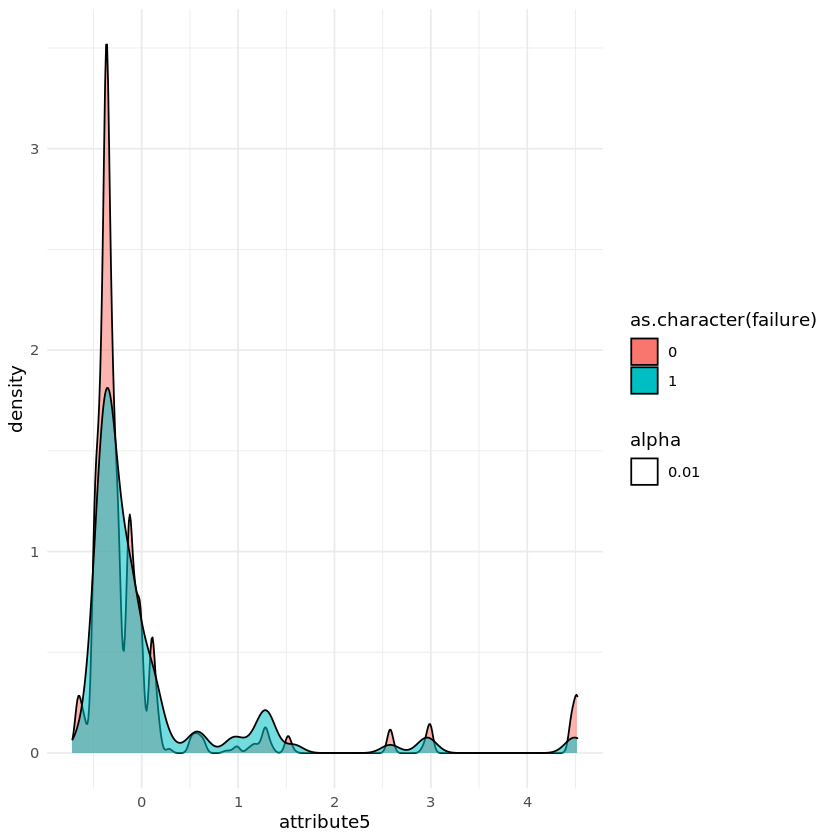

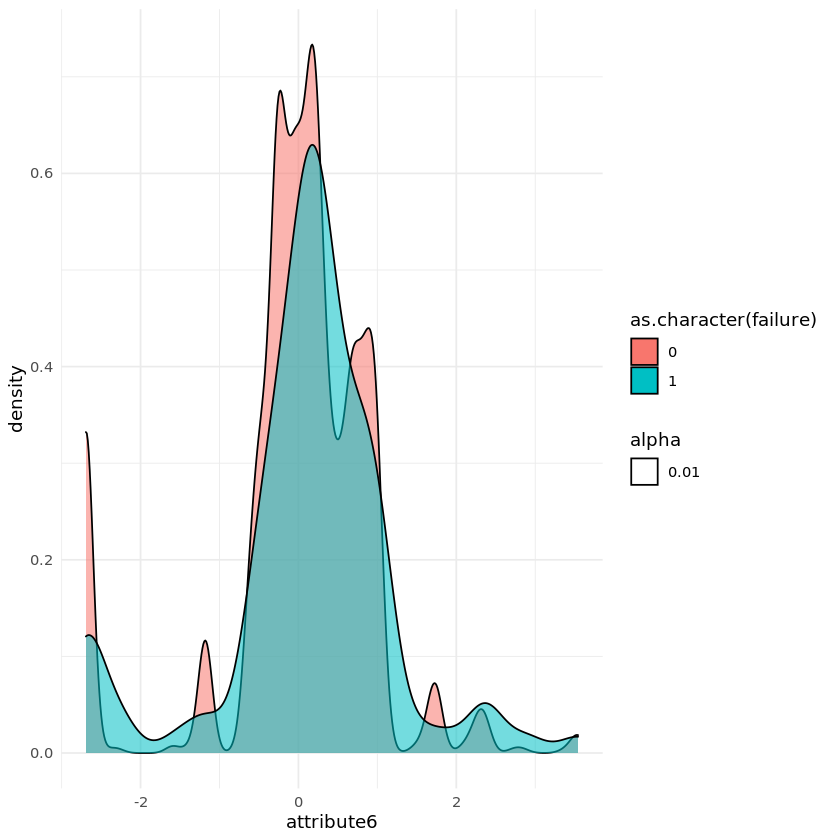

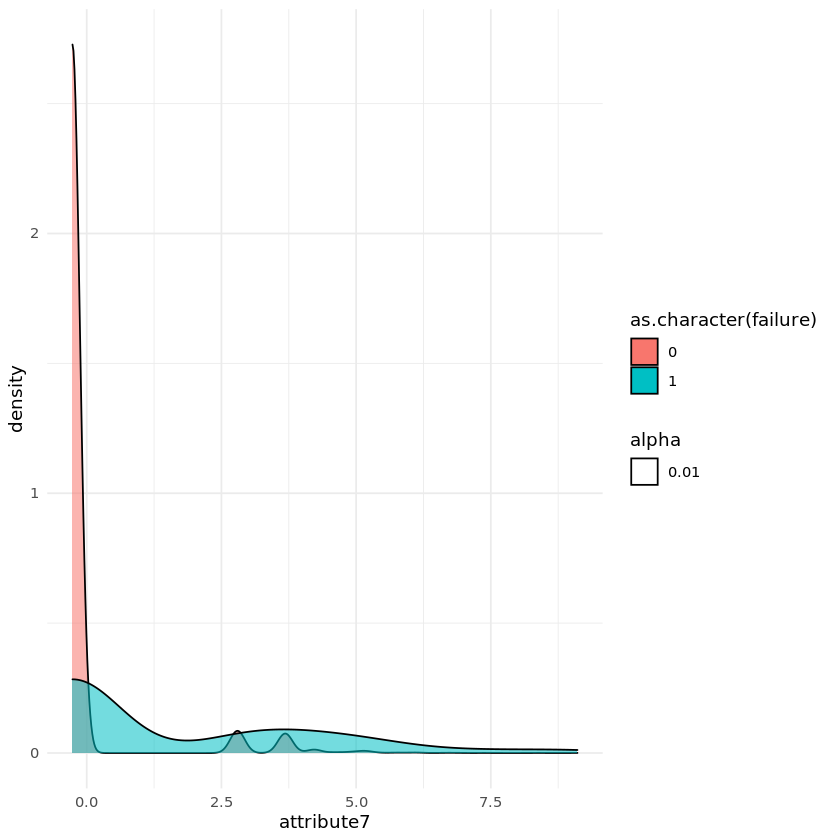

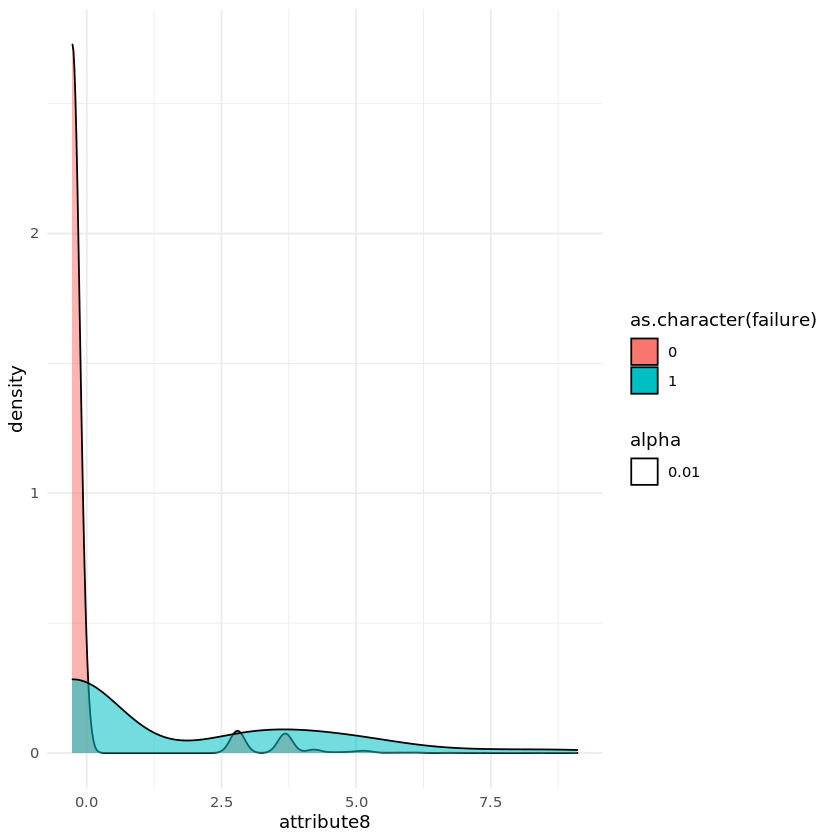

Loading required package: caret
Loading required package: lattice



 NoFailure    Failure 
0.98993197 0.01006803 

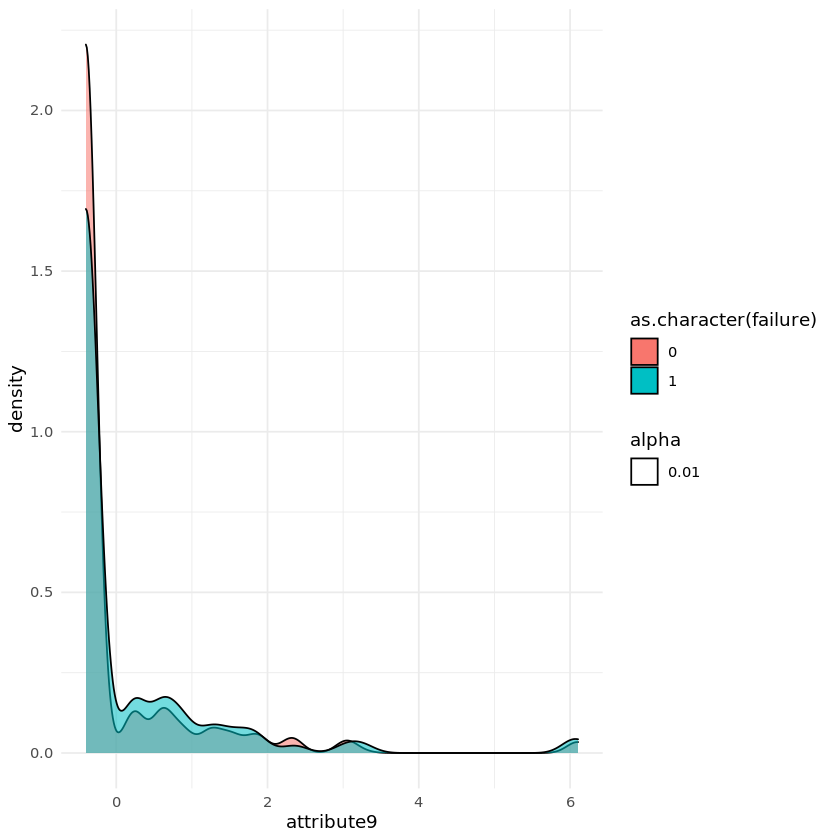

In [5]:
ggplot(data.sample, aes(attribute1, fill =  as.character(failure), alpha=.01)) +
  geom_density() + theme_minimal()
ggplot(data.sample, aes(attribute2, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute3, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute4, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute5, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute6, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute7, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute8, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
ggplot(data.sample, aes(attribute9, fill =  as.character(failure), alpha=.01)) +
  geom_density()  + theme_minimal()
############### Split data 
#nn.fails[, c(4, 6) ] <- NULL
require(caret)
set.seed(0)
data.sample$failure <- factor(data.sample$failure)
levels(data.sample$failure) <- c('NoFailure', 'Failure')
train.index <- createPartition(data.sample)
data.sample$date <- data.sample$device <- NULL
train <- data.sample[train.index, ]
test <- data.sample[-train.index, ]
table(train$failure)/dim(train)[1]

In [6]:
####################   train 
require(MLmetrics)
f1 <- function (data, lev = NULL, model = NULL) {
  precision <- posPredValue(data$pred, data$obs, positive = "Failure")
  recall  <- sensitivity(data$pred, data$obs, positive = "Failure")
  f1_val <- (2 * precision * recall) / (precision + recall)
  names(f1_val) <- c("F1")
  f1_val
} 
fit.control <- trainControl( method = "repeatedcv", number = 3, repeats = 1,
                             allowParallel = TRUE, classProbs = TRUE,
                             summaryFunction = f1,  sampling =  "up")
require(gbm)
require(e1071) # svm impmelemntation 
require(kernlab) # kernels implementation 
require(LiblineaR)
#install.packages('xgboost')
require(xgboost)
#install.packages('LiblineaR')
set.seed(0)

Loading required package: MLmetrics

Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall

Loading required package: gbm
Loaded gbm 2.1.8
Loading required package: e1071
Loading required package: kernlab

Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: LiblineaR
Loading required package: xgboost

Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [7]:
set.seed(0)
gbmFit1 <- train(failure ~ ., data = train, method = "gbm", trControl = fit.control,
                 verbose = TRUE)
gbmFit1
#install.packages('xgboost')


require(randomForest)
rf.Fit1 <- train(failure ~ ., data = train, method = "rf", trControl = fit.control,
                 verbose = TRUE)
rf.Fit1
rlg.Fit1 <- train(failure ~ ., data = train, method = "regLogistic", 
                  trControl = fit.control, verbose = TRUE)
rlg.Fit1

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. F1 will be used instead.”

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3388            -nan     0.1000    0.0238
     2        1.2989            -nan     0.1000    0.0201
     3        1.2651            -nan     0.1000    0.0166
     4        1.2357            -nan     0.1000    0.0146
     5        1.2112            -nan     0.1000    0.0120
     6        1.1909            -nan     0.1000    0.0104
     7        1.1719            -nan     0.1000    0.0094
     8        1.1574            -nan     0.1000    0.0075
     9        1.1436            -nan     0.1000    0.0071
    10        1.1300            -nan     0.1000    0.0066
    20        1.0368            -nan     0.1000    0.0034
    40        0.9214            -nan     0.1000    0.0032
    60        0.8342            -nan     0.1000    0.0020
    80        0.7538            -nan     0.1000    0.0022
   100        0.6816            -nan     0.1000    0.0017
   120        0.6298            -nan     0.1000    0.0016
   140        

Stochastic Gradient Boosting 

7350 samples
  18 predictor
   2 classes: 'NoFailure', 'Failure' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 4900, 4900, 4900 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  interaction.depth  n.trees  F1        
  1                   50      0.06971121
  1                  100      0.06700251
  1                  150      0.06931093
  2                   50      0.06985235
  2                  100      0.07384992
  2                  150      0.08424739
  3                   50      0.07881351
  3                  100      0.09487772
  3                  150      0.10420686

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
F1 was used to select the optimal model using the largest value.
The final values used for the model were n.trees = 150, interaction.depth =
 3, shrinkage 

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. F1 will be used instead.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Random Forest 

7350 samples
  18 predictor
   2 classes: 'NoFailure', 'Failure' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 4901, 4900, 4899 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  mtry  F1        
   2    0.07017544
  10    0.06896552
  18    0.04878049

F1 was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. F1 will be used instead.”

ARGUMENTS SETUP
PROBLEM SETUP
FILL DATA STRUCTURE
SETUP CHECK
TRAIN
......
optimization finished, #iter = 67
Objective value = -3880.238441
COPY MODEL TO WEIGHT VECTOR
FREE SPACE
FREED SPACE


Regularized Logistic Regression 

7350 samples
  18 predictor
   2 classes: 'NoFailure', 'Failure' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 4899, 4901, 4900 
Addtional sampling using up-sampling

Resampling results across tuning parameters:

  cost  loss       epsilon  F1        
  0.5   L1         0.001    0.06351778
  0.5   L1         0.010    0.06208089
  0.5   L1         0.100    0.06142490
  0.5   L2_dual    0.001    0.06468282
  0.5   L2_dual    0.010    0.06393327
  0.5   L2_dual    0.100    0.06788013
  0.5   L2_primal  0.001    0.06325142
  0.5   L2_primal  0.010    0.06313053
  0.5   L2_primal  0.100    0.05841213
  1.0   L1         0.001    0.06364602
  1.0   L1         0.010    0.06266188
  1.0   L1         0.100    0.05820017
  1.0   L2_dual    0.001    0.06341057
  1.0   L2_dual    0.010    0.06476678
  1.0   L2_dual    0.100    0.06352115
  1.0   L2_primal  0.001    0.06244783
  1.0   L2_primal  0.010    0.06360

In [ ]:
require(xgboost)
xgb.Fit1 <- train(failure ~ ., data = train, method = "xgbTree", 
                  trControl = fit.control,
                  verbose = TRUE)
xgb.Fit1

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. F1 will be used instead.”

In [ ]:
resamps <- resamples(list(GBM = gbmFit1, XGB = xgb.Fit1,
                          RF = rf.Fit1, RLG=rlg.Fit1  ))
resamps
summary(resamps)

In [ ]:
summary(diff(resamps))